The source code for this entry can be found at https://github.com/rctcwyvrn/math441-learning-portfolio/blob/master/how_does_linprog_ip_work.ipynb

## What's wrong with linprog?
During class when we want to solve integer programming problems we've used the same `scipy` `linprog` solver that we used for linear programming, but just with the `integrality` parameter set. In class we've claimed that this produces the "optimal" solution for these integer programming problems and we've seen that integer programming is much more efficient than using a bruteforce combinatorial method. Some of the examples of problems we've solved using this method are NP-complete, problems that are currently unknown to be solvable in polynomial time. 

While reading the register allocation paper they mention that the ip solver finds the 'optimal graph coloring', which seems weired to me. do ip solvers actualy solve ip problems optimally???

This seems to present us with a contradiction
- NP-complete problems like sudoku can be represented using an IP problem
- IP problems can be solved optimally and efficiently using `linprog`'s integer programming solver
- It is currently unknown if NP-complete problems can be efficiently solved

So I believe there's some details that we glossed over when using `linprog` in class. Obviously `linprog` doesn't imply P=NP so we must be missing something here

Possibility #1: `linprog` fails to find the optimal solution in all cases. Maybe it only solves IP problems optimally _most_ of the time

Possibility #2: `linprog` explodes in runtime in some edge cases. Maybe it only has a polynomial average runtime, but an exponential worst case runtime

It seems likely that the real reason is some combination of the two, so let's find out!

## Mixed integer linear programming (MILP)

Mixed-integer linear programming problems are things we've encountered over and over while analyzing problems in class so I don't need to explain why they're important.

But how do solvers account for the fact that some of the parameters must be integers? Linear programming typically solves for values over the reals. How does it handle binary values like what we've seen in many IP decision variables? You can't just round to the nearest integer if you have a value between 0 and 1.

linprog is a wrapper around highs https://highs.dev/

how does highs solve MIP problems? https://en.wikipedia.org/wiki/HiGHS_optimization_solver#Mixed_integer_programming branch-and-cut solver?

Looking up branch and cut leads us to this paper, which states https://www.sciencedirect.com/science/article/abs/pii/S0167819120301071  "However, finding the optimal answer of ILP models is an NP-Hard problem and remains a computational challenge. "

Aha! it isn't optimal! so there must be cases where these algorithms fail. That answers the big question I had asked, these algorithms are just approximations and will sometimes not find the optimal solution.

So what exactly are these algorithms, how do they work and why exactly do they fail?

## Branch and cut
The wikipedia article for branch and cut provides an outline for how the algorithm operates. The core idea is taht we want to generate a tree of possible solutions that contains the entire solution space, with the property that the children of a node should be related to their parent in some way. Then because of the above property, we can delete a node and ignore all if it's children if we find that the node is not as good as our current solution. So we want to branch (build up these related subproblems) and bound (delete entire branches of the tree that are related to a bad solution).

So that's the general idea, but the big question is how do we do those branch and bound operations in a way that actually makes sense?

The core idea behind it lies in the linear relaxation of an integer programming problem. When you compute the optimal value of a linear relaxation of an integer programming problem, that represents an upper bound on all feasible solutions to that problem, including the integral optimal solution that we want. (assuming this is a maximization problem)

Why is this useful? Well we can take the feasible solution space and split it down the middle to produce two spaces that we can search for an optimal solution in. Running the linearly relaxed problem on the two smaller feasible spaces will give us an upper bound on both of those spaces based on the argument in the last paragraph.

What do we do with these upper bounds? Well if we already have an integral solution with a better value than one of those upper bounds, then we know that any integral solution in that space must be not as good, so we can simply ignore it!


### Cutting planes
http://homes.di.unimi.it/righini/Didattica/ComplementiRicercaOperativa/MaterialeCRO/2005%20Revival%20of%20Gomory%20cuts.pdf

Branch and cut can be further improved by considering cutting planes, which is a way if iteratively refining a non-integral solution into an integral one. The idea is pretty simple, a non-integral solution must either lie inside or outside of the convex hull representing the integral solution space. There's a theorem that states that for an optimal non-integral solution that lies on a corner, then there exists a hyperplane that lies between that solution and the convex hull for the integral solution space. This hyperplane can be used as an inequality, which is called a _cut_, more specifically Gomory's cut.

What does this cut accomplish? Intuitively this adds a "wall" that pushes the relaxed problem towards the convex hull. We can compute another optimal value after adding this wall and then add another cut, adding another "wall". Doing this over and over will push the non-integral solution to the nearest point on the convex hull, which hopefully corresponds to the optimal integral solution.

### Problems with branch and cut

Ignoring cutting planes for a moment, it appears that branch and bound is an algorithm that will always produce the optimal solution.
1. The upper bound property of the linear relaxation is obvious since it's the optimal value
2. Since the subproblems are direct subsets of the original problem, once we have the true bound it's always true that we can ignore that subproblem and any of it's child subproblems.

Based on these two facts it appears that branch and bound will always successfully find the optimal value, so what's going on here? Does this show $P=NP$??

The answer lies in algorithmnic analysis of branch and bound. What happens if branch and bound is never able to remove any subproblems? In that case then it would have to compute the linear relaxation on every single subproblem, never getting an integral solution until the bounds themselves were all integers. The tree in that case would have exponential size in the number of parameters, making branch and bound not a polynomial time algorithm in that case.

So basically, my guess is that there's some degenrate cases for each branch and bound variant that will make it have to compute the entire tree and take exponential time, so since computational complexity is all about worst case runtime, branch and bound is not polytime. However as I notcied after implementing it myself, it is very fast in most cases, making it a usually polynomial time algorithm that returns exact results! Very cool!

# Conclusion
So what did we learn? 

Integer programming is still a NP-hard problem which takes exponential time in the worst case to run, but there exist algorithms that can compute the optimal solution fairly quickly in most cases. Surprisingly the degenerate cases that cause the worst case runtime to be exponential are quite rare, and branch and bound is able to compute the optimal integer programming solution quickly in the vast majority of problems. This is an interesting dichotomy because we know that many computationally difficult programs can be reduced to integer programming, yet integer programming solvers are actually quite efficient and can produce optimal values pretty easily.


I had expected the linear relaxation based solvers to have the opposite problem, always fast but sometimes not being able to find the optimal solution. My intuition was that linear relaxation would give a non-integral solution that you would somehow try to round to an integral solution, and this would be a fast process that would sometimes result in rounding to the wrong answer. In a way I was sorta right (this is kinda the basis behind Gomory's cut and it's iterative process) and that sort of algorithm would work, but be very impractical. A value that gets rounded to 1 instead of 0 can mean a drastically different (or totally infeasible) solution after all, so it makes sense that what I had thought was wrong. My intuition was that an algorithm that used linear relaxation could not possibly find the optimal integral solution without resorting to iterating through all the solutions, but after learning about how branch and bound works it all seems so simple and obvious in hindsight.



In [94]:
from scipy.optimize import linprog
import math
from geopy.distance import geodesic
import numpy as np
from global_land_mask import globe

In [95]:
def branch_on(c, A, b, bounds, solution):
    # given the current solution, create two subproblems using the "most infeasible" heuristic

    dist_from_point_5 = []
    for x in solution:
        frac = round(x,1) - round(x)
        dist_from_point_5.append(abs(frac - 0.5))

    
    choice = dist_from_point_5.index(min(dist_from_point_5))

    lb, ub = bounds[choice]
    x = solution[choice]
    bounds_A = list(bounds) 
    bounds_A[choice] = (lb, math.floor(x))
    bounds_B = list(bounds)
    bounds_B[choice] = (math.ceil(x), ub)

    # print(solution)
    # print(f"Choosing x_{choice} | x_{choice} = {solution[choice]} | bounds = {bounds[choice]} | new bounds = {bounds_A[choice]}, {bounds_B[choice]}")

    return [(c, A, b, bounds_A), (c, A, b, bounds_B)]

def branch_and_bound_solver(c, A, b, bounds):
    # minimize, subject to Ax <= b, the given bounds, and that each x is an integer

    best_integral_solution = None
    best_integral_val = None
    active_problems = []
    active_problems.append([c, A, b, bounds])
    i = 0
    while len(active_problems) != 0:
        i += 1
        c, A, b, bounds = active_problems.pop()
        relaxed_result = linprog(c, A, b, bounds=bounds)
        if not relaxed_result.success:
            continue

        if best_integral_val != None and relaxed_result.fun >= best_integral_val:
            continue
        
        if all([f.is_integer() for f in relaxed_result.x]):
            print(f"{i} | Solution is integral | val = {relaxed_result.fun}")
            best_integral_val = relaxed_result.fun
            best_integral_solution = relaxed_result.x
        
        for subproblem in branch_on(c, A, b, bounds, relaxed_result.x):
            active_problems.append(subproblem)
    print(f"Finished after {i} iterations")
    return (best_integral_val, best_integral_solution)

In [96]:
import googlemaps
import requests
from geopy.distance import geodesic, distance
import io
from PIL import Image

api_key = open("../project/googlemaps-apikey.txt", "r").read()
client = googlemaps.Client(key=api_key)
vancouver_center = (49.249828, -123.125774)
vancouver_top_left = (49.295863, -123.270310)
vancovuer_bottom_right = (49.196127, -123.021401)

def get_map(center, markers=[], fills=[], zoom=11):
    static_map_url = "https://maps.googleapis.com/maps/api/staticmap?"
    lat,long = center
    center = str(lat)+","+str(long)
    req = f"{static_map_url}center={center}&zoom={str(zoom)}&size=400x400&key={api_key}&sensor=false"
    
    for color, points in markers:
        req += f"&markers=color:{color}|" + "|".join([str(lat)+","+str(long) for lat,long in points])

    for points in fills:
        path = "&path=color:0x00000000|weight:5|fillcolor:0xf55742|" + "|".join([str(lat)+","+str(long) for lat,long in points])
        req = req + path

    r = requests.get(req)
    if "X-Staticmap-API-Warning" in r.headers:
        print(r.headers["X-Staticmap-API-Warning"])
        return None
    return Image.open(io.BytesIO(r.content))

def circle_around(center):
    n = 25
    r = 3
    circle = []
    for i in range(n):
        rad = i/n * 2 * math.pi
        deg = 180 * rad/math.pi 
        point = distance(r).destination(center, bearing=deg)
        circle.append((point.latitude, point.longitude))
    return circle

def display_solution(center, problem, chosen_indicies, show_problem_points=False, show_coverage=False, show_circular_coverage=False):
    chosen_points = []
    for i in chosen_indicies:
        chosen_points.append(problem[i])
    
    fills = []
    if show_circular_coverage:
        for lat,long in chosen_points:
            fills.append(circle_around((lat,long)))
            # break
    if show_problem_points:
        return get_map(center, markers=[("red", chosen_points), ("blue", problem)], fills=fills, zoom=11)
    else:
        return get_map(center, markers=[("red", chosen_points)], fills=fills, zoom=11)

def equidistant_points(center=vancouver_center, top_left = vancouver_top_left, bottom_right = vancovuer_bottom_right, height=20, width=20, unit=1.5):    
    lat_max = top_left[0]
    long_min = top_left[1]
    lat_min = bottom_right[0]
    long_max = bottom_right[1]
    points = []
    for x in range(width//2):
        x_dist = distance(unit * x)
        for y in range(height//2):
            y_dist = distance(unit * y)
            for x_dir in [0, 180]:
                if x == 0 and x_dir == 180:
                    continue
                for y_dir in [90, 270]:
                    if y == 0 and y_dir == 270:
                        continue
                    p = y_dist.destination(x_dist.destination(center, bearing=x_dir), bearing=y_dir)
                    points.append((p.latitude, p.longitude))
            # points.append((center[0] - y*unit, center[1] - x*unit))
            # points.append((center[0] - y*unit, center[1] + x*unit))
            # points.append((center[0] + y*unit, center[1] - x*unit))
            # points.append((center[0] + y*unit, center[1] + x*unit))
    # print(points[:10])
    points = list(filter(lambda p: lat_min <= p[0] <= lat_max and long_min <= p[1] <= long_max, points))
    return points

def make_set_covering_problem_straight_line(positions):
    print(f"Creating set covering matrix (n = {len(positions)}) (straight line distances)")
    covering_matrix = np.array([])
    for start in positions:
        covered = []
        for other in positions:
            if geodesic(start, other).kilometers < 3.0:
                covered.append(1)
            else:
                covered.append(0)
        covering_matrix = np.hstack((covering_matrix, covered))
    return covering_matrix.reshape(len(positions), len(positions))

In [97]:
def set_covering_custom_solver(problem, matrix):
    c = np.ones(len(problem))
    b = -np.ones(len(problem))
    A = -matrix
    bounds = [(0,1) for _ in problem]
    val, decisions = branch_and_bound_solver(c, A, b, bounds)
    solution = []
    for i,chosen in enumerate(decisions):
        if round(chosen) == 1:
            solution.append(i)
    return solution

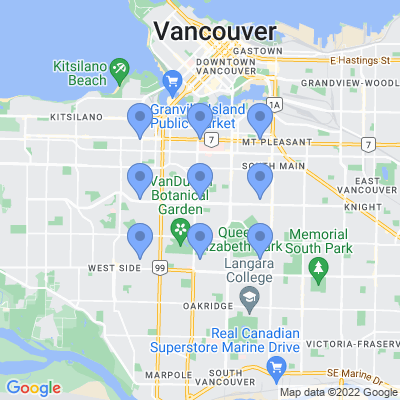

In [98]:
small_problem = equidistant_points(height=4, width=4)
display(get_map(vancouver_center, markers=[('blue', small_problem)],zoom=12))

Creating set covering matrix (n = 9) (straight line distances)
1 | Solution is integral | val = 1.0
Finished after 3 iterations


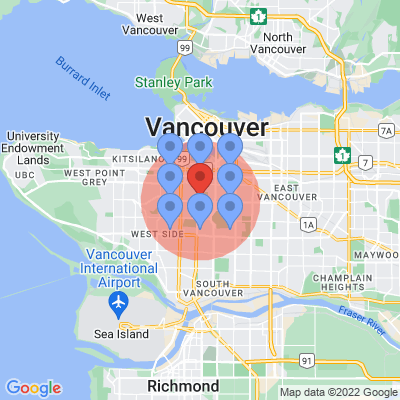

In [109]:
matrix = make_set_covering_problem_straight_line(small_problem)
solution = set_covering_custom_solver(small_problem, matrix)
display_solution(vancouver_center, small_problem, [round(x) for x in solution], show_problem_points=True, show_circular_coverage=True)

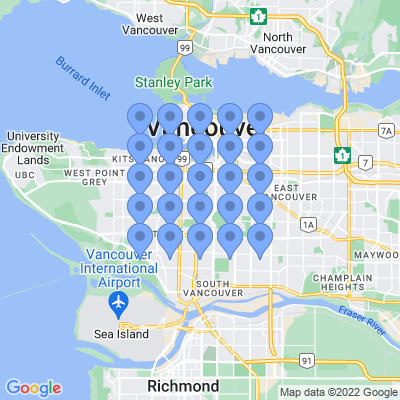

Creating set covering matrix (n = 25) (straight line distances)
2 | Solution is integral | val = 4.0
Finished after 17 iterations


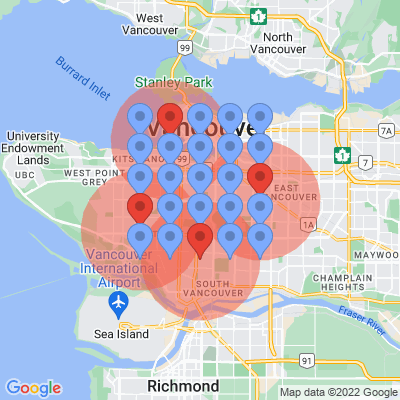

In [ ]:
larger_problem = equidistant_points(height=6, width=6)
display(get_map(vancouver_center, markers=[('blue', larger_problem)]))
matrix = make_set_covering_problem_straight_line(larger_problem)
solution = set_covering_custom_solver(larger_problem, matrix)
display_solution(vancouver_center, larger_problem, [round(x) for x in solution], show_problem_points=True, show_circular_coverage=True)

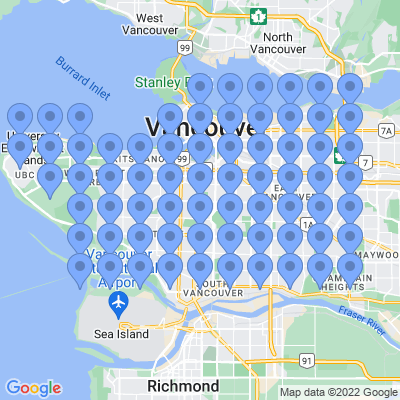

Creating set covering matrix (n = 69) (straight line distances)
4 | Solution is integral | val = 9.0
Finished after 427 iterations


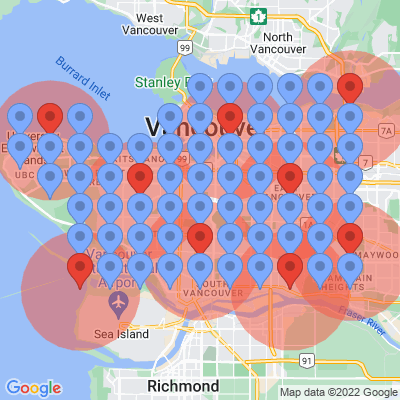

In [ ]:
full_problem = list(filter(lambda p: globe.is_land(p[0], p[1]), equidistant_points()))
display(get_map(vancouver_center, markers=[('blue', full_problem)]))
matrix = make_set_covering_problem_straight_line(full_problem)
solution = set_covering_custom_solver(full_problem, matrix)
display_solution(vancouver_center, full_problem, [round(x) for x in solution], show_problem_points=True, show_circular_coverage=True)

In [ ]:
%timeit solution = set_covering_custom_solver(full_problem, matrix)

4 | Solution is integral | val = 9.0
Finished after 427 iterations
4 | Solution is integral | val = 9.0
Finished after 427 iterations
4 | Solution is integral | val = 9.0
Finished after 427 iterations
4 | Solution is integral | val = 9.0
Finished after 427 iterations
4 | Solution is integral | val = 9.0
Finished after 427 iterations
4 | Solution is integral | val = 9.0
Finished after 427 iterations
4 | Solution is integral | val = 9.0
Finished after 427 iterations
4 | Solution is integral | val = 9.0
Finished after 427 iterations
874 ms ± 85.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Creating set covering matrix (n = 198) (straight line distances)
Starting solver
8 | Solution is integral | val = 12.0
66 | Solution is integral | val = 11.0
Finished after 7629 iterations


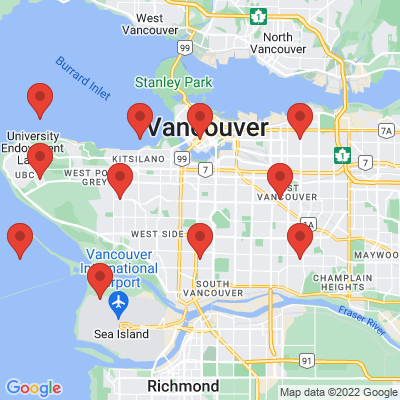

In [123]:
massive_problem = equidistant_points(height=30, width=30, unit=1.0)
# display(get_map(vancouver_center, markers=[('blue', massive_problem)]))
matrix = make_set_covering_problem_straight_line(massive_problem)
print("Starting solver")
solution = set_covering_custom_solver(massive_problem, matrix)
display_solution(vancouver_center, massive_problem, [round(x) for x in solution], show_problem_points=False, show_circular_coverage=False)